In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%cd /gdrive/My Drive/Colab Notebooks/Internship/Musk AND Non-Musk Molecule

/gdrive/My Drive/Colab Notebooks/Internship/Musk AND Non-Musk Molecule


In [4]:
# Libraries

import numpy as np
import pandas as pd
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Conv1D, Dropout, Flatten, LSTM

from sklearn.manifold import TSNE
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score


Using TensorFlow backend.


# Info About Columns In Data

* molecule_name: Symbolic name of each molecule. Musks have names such as MUSK-188. Non-musks have names such as NON-MUSK-jp13.

* conformation_name: Symbolic name of each conformation. These have the format MOL_ISO+CONF, where MOL is the molecule number, ISO is the stereoisomer number (usually 1), and CONF is the conformation number.

* f1 through f162: These are "distance features" along rays (see paper cited above). The distances are measured in hundredths of Angstroms. The distances may be negative or positive, since they are actually measured relative to an origin placed along each ray. The origin was defined by a "consensus musk" surface that is no longer used. Hence, any experiments with the data should treat these feature values as lying on an arbitrary continuous scale. In particular, the algorithm should not make any use of the zero point or the sign of each feature value.

* f163: This is the distance of the oxygen atom in the molecule to a designated point in 3-space. This is also called OXY-DIS.

* f164: OXY-X: X-displacement from the designated point.

* f165: OXY-Y: Y-displacement from the designated point.

* f166: OXY-Z: Z-displacement from the designated point.

* class: 0 => non-musk, 1 => musk

In [0]:
df1 = pd.read_csv('Musk_nonMusk.csv')

# EDA

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 170 entries, ID to class
dtypes: int64(168), object(2)
memory usage: 8.6+ MB


In [7]:
df1.head()

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80,1
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80,1


### Checking For Null Values In The Data

In [8]:
null_vals = df1.isnull().any()
if list(null_vals) is True:
  print("Null Value Present")
else:
  print("No NUll Values")

No NUll Values


***So we conclude there are No Null Values***

In [9]:
df1.tail()

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
6593,6594,NON-MUSK-jp13,jp13_2+5,51,-123,-23,-108,-117,134,-160,82,-230,-28,-150,-63,-55,-77,-108,-308,-221,-41,-57,12,-112,-183,-198,-35,137,-198,-168,-153,-51,252,-108,135,-121,119,-120,73,28,...,224,-18,-96,43,1,-76,-53,-38,-23,-176,-32,-205,-95,-124,-139,-153,-170,-178,-102,-113,-42,-67,-141,-96,-112,-113,-47,124,-12,62,-66,164,-14,-29,107,171,-44,-115,118,0
6594,6595,NON-MUSK-jp13,jp13_2+6,44,-104,-19,-105,-117,142,-165,68,-225,-32,-124,-77,-43,-74,-100,-291,-215,-25,-49,6,-121,-183,-201,-54,127,-204,-164,-160,-41,255,-117,-104,-14,133,-157,141,46,...,232,-6,-146,-88,-75,-74,-55,-30,-28,-175,-48,-202,-86,-125,-138,-154,-169,-178,-102,-123,-32,-52,-136,-98,-109,-112,-56,-49,-85,60,-51,166,-9,150,129,158,-66,-144,-5,0
6595,6596,NON-MUSK-jp13,jp13_2+7,44,-102,-19,-104,-117,72,-165,65,-219,-12,-107,-66,-58,-82,-77,-288,-214,-21,-58,-32,-93,-183,-197,-71,218,-217,-164,-161,-59,243,-117,-103,-14,118,-157,140,-150,...,167,-13,-188,-89,-117,-57,-47,-33,-28,-175,-50,-216,-129,-130,-138,-155,-169,-178,-102,-124,-32,-51,-136,-98,-123,-112,-55,-47,-84,-226,90,117,-8,150,130,159,-66,-144,-6,0
6596,6597,NON-MUSK-jp13,jp13_2+8,51,-121,-23,-106,-117,63,-161,79,-224,-30,-129,-54,-60,-86,-88,-307,-221,-39,-58,-12,-86,-184,-180,-61,221,-211,-168,-154,-63,243,-107,136,-121,116,-122,73,-155,...,167,7,-170,43,-6,-61,-47,-43,-23,-176,-33,-212,-131,-113,-139,-153,-170,-178,-103,-114,-42,-66,-141,-96,-123,-113,-46,124,-11,-238,86,99,-14,-31,106,171,-44,-116,117,0
6597,6598,NON-MUSK-jp13,jp13_2+9,51,-122,-23,-106,-117,190,-161,80,-227,-52,-139,-63,-51,-79,-99,-122,-220,-35,-57,6,-104,-183,-196,-51,63,-204,-169,-154,63,128,-108,135,-121,42,-122,73,-90,...,98,-57,-152,43,-4,-69,-51,-37,-23,-175,-33,-209,-108,-125,-139,-153,-170,-178,-102,-115,-42,-66,-141,-96,-110,-113,-46,124,-11,95,40,124,-14,-30,107,171,-44,-115,118,0



Based on the above observation we can see that molecule_name is suffixed by the conformation name & conformation_name is sufffixed by the counting of the conformation_name.

> *Thus, we can separate the compound name from molecule name, and can get the conformation name from molecule_name itself*

(Splitting by '-')

In [10]:
comp_name = []
conf_name = []

for i in df1['molecule_name'].tolist():
    temp  = i.split('-')
    comp_name.append(temp[0]) if len(temp)==2  else comp_name.append(temp[0]+' '+temp[1])
    conf_name.append(temp[1]) if len(temp)==2 else conf_name.append(temp[2])

print("Number of conformation names in the data = ", len(Counter(conf_name)))
print("Number of compound names = ", len(Counter(comp_name)))

Number of conformation names in the data =  102
Number of compound names =  2


In [0]:
df1['compound_name'] = comp_name
df1['conformation_name'] = conf_name

In [12]:
df1.head(3)

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class,compound_name
0,1,MUSK-211,211,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1,MUSK
1,2,MUSK-211,211,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1,MUSK
2,3,MUSK-211,211,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1,MUSK


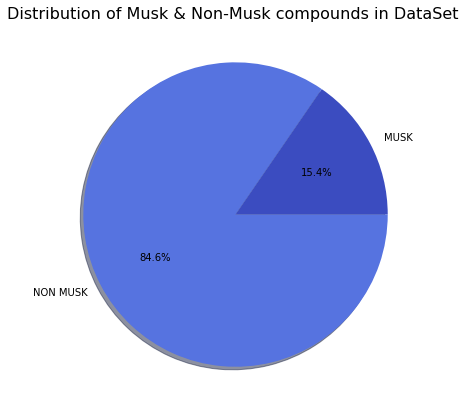

In [13]:
plt.figure(figsize=(7,7))
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, 12)]
n_compounds = Counter(comp_name)
plt.pie(list(n_compounds.values()), labels=list(n_compounds.keys()), autopct="%1.1f%%", shadow=True, colors=colors)
plt.title('Distribution of Musk & Non-Musk compounds in DataSet ', fontsize=16)
plt.show()

* The PieChart shows that the data is pretty much imbalanced as non-musk compounds are 84.6% of the data while musk compounds are just 15.4% of the Data.

* It could be benefitial for us to try to see if there are some common properties b/w these two classes or not

> *thus, now I will be dividing data into musk and non musk, to find out various properties of the data*

In [0]:
musk_data = df1.loc[df1['compound_name']=='MUSK']
non_Musk_data = df1.loc[df1['compound_name']=='NON MUSK']
class_ = df1['class'].tolist()
df1.drop(['class'], axis=1, inplace=True)

In [0]:
def bar_plot(data_dict,x_label='', y_label='',title='', size=[7,5], annot=False):
    plt.figure(figsize=(size[0], size[1]))
    x = list(data_dict.keys())
    y = list(data_dict.values())
    sns.set_style("darkgrid")
    ax = sns.barplot(x,y)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    try:
        int(x[0])
        plt.xticks(range(len(y)), sorted(x), rotation=40)
    except:
        plt.xticks(range(len(y)), x)
    if annot:
        for p  in (ax.patches) :
            ax.annotate( "%d" %(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=12, color='black', rotation=5, xytext=(0, 5),
                        textcoords='offset points')
    plt.grid()
    plt.title(title)

    plt.show()

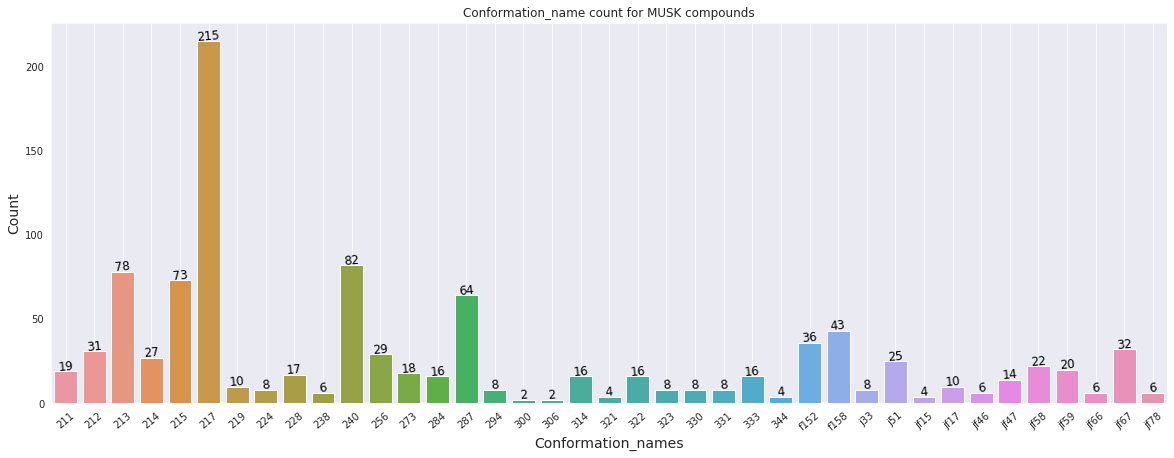

Total number of unique conformation names for MUSK compounds are =  39


In [16]:
xlabel='Conformation_names'
ylabel='Count'
title='Conformation_name count for MUSK compounds'
bar_plot(Counter(musk_data['conformation_name']), x_label=xlabel, y_label=ylabel, title=title, size=[20,7], annot=True)
print("Total number of unique conformation names for MUSK compounds are = ", len(Counter(musk_data['conformation_name'])))

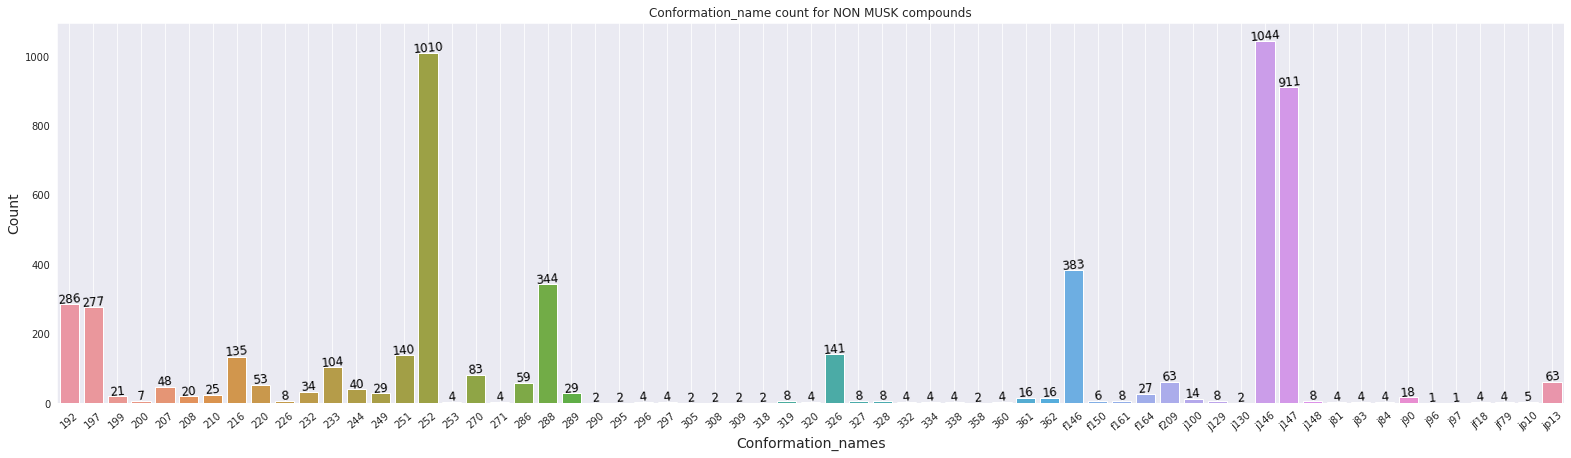

Total number of unique conformation names for NON MUSK compounds are =  63


In [17]:
title='Conformation_name count for NON MUSK compounds'
bar_plot(Counter(non_Musk_data['conformation_name']),x_label=xlabel, y_label=ylabel, title=title, size=[27,7], annot=True)
print("Total number of unique conformation names for NON MUSK compounds are = ", len(Counter(non_Musk_data['conformation_name'])))


By looking at the above two bar plots for MUSK and NON MUSK compounds, we can say that:- 

* The conformation names are not very well 
distributed b/w the two classes. 

* Also both of compounds do not have any common conformation names.


Now Let's look at the numerical features in the dataset

In [18]:
num_features = df1.select_dtypes(include = [np.number])

num_features.head()

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166
0,1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,40,-27,...,-27,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96
1,2,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,2,-144,...,17,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79
2,3,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,3,-129,...,41,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39
3,4,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,3,-144,...,17,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80
4,5,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,3,-144,...,17,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80


In [19]:
# removing ID from the features
num_features.drop(['ID'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
num_features.head(3)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,...,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166
0,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,40,-27,68,...,-27,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96
1,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,2,-144,38,...,17,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79
2,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,3,-129,37,...,41,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39


In [21]:
# Normalizig the numerical features
normalized_features = df1.select_dtypes(include = [np.number])
normalized_features.drop(['ID'], axis=1, inplace=True)
for i in normalized_features.columns:
    feature  = normalized_features[i].tolist()
    max_ = max(feature)
    normalized_features[i] = [j/float(max_) for j in feature]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  




---
**TSNE** -> **T**-distributed **S**tochastic **N**eighbor **E**mbedding.
  
>  **TSNE** is a dimensionality reduction technique used to represent high-dimensional dataset in a low-dimensional space of two or three dimensions so that we can visualize it.

> It constructs probability distributions in such a way that similar samples have a high likelihood of being picked while dissimilar points have an extremely small likelihood of being picked.


---




In [0]:
# The perplexity is related to the number of nearest neighbors
# perplexity is 150 learning rate is 5000

title_tsne_bow = TSNE(n_components=2, perplexity=150, learning_rate=5000)
X_embedding = title_tsne_bow.fit_transform(num_features)

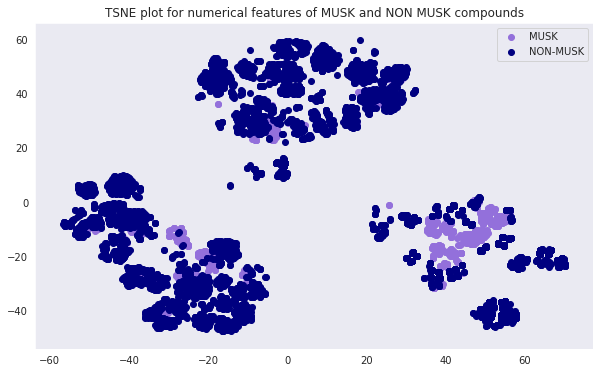

In [23]:

Musk = [i for i,j in zip(X_embedding, class_) if j==1]
Non_musk = [i for i,j in zip(X_embedding, class_) if j==0]

colors = {0:'navy', 1:'mediumpurple', 2:'green'}
plt.figure(figsize=(10,6))
plt.scatter([i[0] for i in Musk], [i[1] for i in Musk], c='mediumpurple',label='MUSK')
plt.scatter([i[0] for i in Non_musk], [i[1] for i in Non_musk], c='navy',label='NON-MUSK')
plt.legend()
plt.grid()
plt.title('TSNE plot for numerical features of MUSK and NON MUSK compounds')
plt.show()

In [0]:
title_tsne_bow = TSNE(n_components=2, perplexity=150, learning_rate=5000) # perplexity is 150 learning rate is 5000
X_embedding = title_tsne_bow.fit_transform(normalized_features)

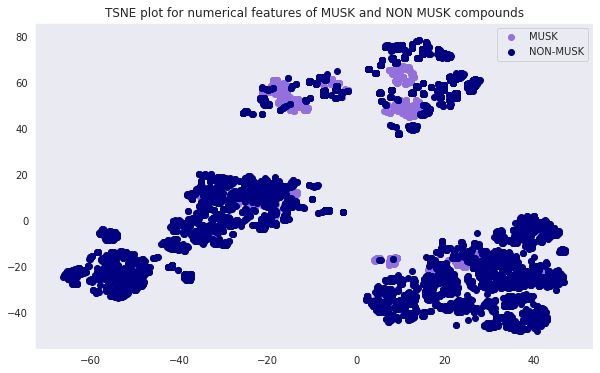

In [25]:

Musk = [i for i,j in zip(X_embedding, class_) if j==1]
Non_musk = [i for i,j in zip(X_embedding, class_) if j==0]

colors = {0:'navy', 1:'mediumpurple', 2:'green'}
plt.figure(figsize=(10,6))
plt.scatter([i[0] for i in Musk], [i[1] for i in Musk], c='mediumpurple',label='MUSK')
plt.scatter([i[0] for i in Non_musk], [i[1] for i in Non_musk], c='navy',label='NON-MUSK')
plt.legend()
plt.grid()
plt.title('TSNE plot for numerical features of MUSK and NON MUSK compounds')
plt.show()


In the above two TSNE plot we can see that both plots have the overlaping MUSK and NON MUSK compounds.

Therefore we need to test the data with both normalization and without normalization to know if which gives better performance with our model.

In [0]:
# Dividing data into train, validation and test sets

# For numeric features without normalization
X_train, X_cv, Y_train, Y_cv = train_test_split(num_features, class_, test_size=0.2)

# For numeric features with normalization
X_train_n, X_cv_n, Y_train_n, Y_cv_n = train_test_split(normalized_features, class_, test_size=0.2)

In [0]:
class roc_callback(keras.callbacks.Callback):
    def __init__(self,training_data,validation_data):
        
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
 
    def on_epoch_end(self, epoch, logs={}):        
        y_pred = self.model.predict(self.x)
        y_train = []
        y_pred_train = []
        for i in range(len(y_pred)):
            y_pred_train.append(y_pred[i][1])
            y_train.append(self.y[i][1])
        roc = roc_auc_score(y_train, y_pred_train)
        
        y_pred_val = self.model.predict(self.x_val)
        y_cv=[]
        y_pred_cv = []
        for i in range(len(y_pred_val)):
            y_pred_cv.append(y_pred_val[i][1])
            y_cv.append(self.y_val[i][1]) 
        roc_val = roc_auc_score(y_cv, y_pred_cv)   
        
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

In [0]:
def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        predictions.append(1 if i>=threshold else 0)
    return predictions

def precision(arr):
    arr = arr.astype(float)
    for i in range(2):
        x = arr[0][i]+arr[1][i]
        arr[0][i] = arr[0][i]/x
        arr[1][i] = arr[1][i]/x
    return arr
def recall(arr):
    arr = arr.astype(float)
    for i in range(2):
        x = arr[i][0]+arr[i][1]
        arr[i][0] = float(arr[i][0]/x)
        arr[i][1] = float(arr[i][1]/x)
    return arr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [0]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [0]:

def confussion_matrix(pred, actual, t ):
    # https://datatofish.com/confusion-matrix-python/
    d = {'y_Predicted': pred,
         'y_Actual': actual
         }
    df = pd.DataFrame(d, columns=['y_Actual','y_Predicted'])
    a = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    p = precision(np.array(a))
    p = pd.DataFrame(p, columns=['0', '1'])
    r = recall(np.array(a))
    r = pd.DataFrame(r, columns=['0', '1'])

    fig = plt.figure(figsize=(15,4))
    plt.subplot(1, 3, 1)
    ax = sns.heatmap(a,cbar=False, fmt='g', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('confusion matrix '+t)

    plt.subplot(1, 3, 2)
    df_corr = p.corr()
    ax = sns.heatmap(p,cbar=False, fmt='g', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('precision matrix '+t)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.subplot(1, 3, 3)
    ax = sns.heatmap(r,cbar=False, fmt='g', annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('recall matrix '+t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    plt.close()


In [0]:

# one-hot-encoding the class category for softmax classification
y_train =  np.asarray(Y_train)
y_train = np_utils.to_categorical(y_train, 2)

y_cv = np.asarray(Y_cv)
y_cv = np_utils.to_categorical(y_cv, 2)

y_train_n =  np.asarray(Y_train_n)
y_train_n = np_utils.to_categorical(y_train_n, 2)

y_cv_n = np.asarray(Y_cv_n)
y_cv_n = np_utils.to_categorical(y_cv_n, 2)

# Models

## MLP -> Multilayer Perceptron

In [32]:

start = Input(shape=(166))
layer = Dense(166, activation='relu')(start)
layer = Dropout(0.5)(layer)
layer = Dense(100, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(50, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(64, activation='relu')(layer)
layer = Dropout(0.5)(layer)
end = Dense(2, activation='softmax')(layer)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
mlp_model = Model(start, end)
mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### **Model training and evaluation for numeric data without normalization**

In [34]:
X_train = np.asarray(X_train)
X_cv = np.asarray(X_cv)
history_1 = mlp_model.fit(x = X_train, y=y_train, batch_size=100, epochs=10, validation_data=(X_cv, y_cv), 
                          callbacks=[roc_callback(training_data=[X_train, y_train],validation_data=[X_cv, y_cv] )])

Train on 5278 samples, validate on 1320 samples
Epoch 1/10
roc-auc: 0.8168 - roc-auc_val: 0.8286                                                                                                    
5278/5278 [==============================] - 2s 422us/sample - loss: 27.6490 - acc: 0.6965 - val_loss: 0.6489 - val_acc: 0.8508
Epoch 2/10
roc-auc: 0.8384 - roc-auc_val: 0.8421                                                                                                    
5278/5278 [==============================] - 0s 81us/sample - loss: 6.1919 - acc: 0.7281 - val_loss: 0.3658 - val_acc: 0.8629
Epoch 3/10
roc-auc: 0.8344 - roc-auc_val: 0.8431                                                                                                    
5278/5278 [==============================] - 0s 74us/sample - loss: 3.1110 - acc: 0.7588 - val_loss: 0.3360 - val_acc: 0.8530
Epoch 4/10
roc-auc: 0.8661 - roc-auc_val: 0.8752                                                                             

validation score: 0.26776495359160685
validation accuracy: 0.8530303


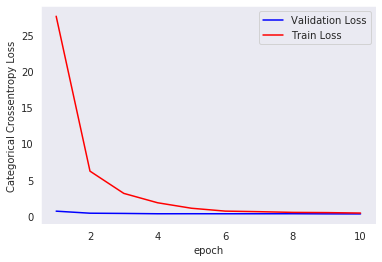

In [35]:

score = mlp_model.evaluate(X_cv, y_cv, verbose=0) # getting model scores
print('validation score:', score[0])
print('validation accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

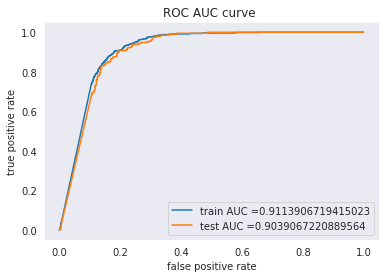

In [36]:
y_train_pred = list(mlp_model.predict(X_train, batch_size=100))
y_cv_pred = list(mlp_model.predict(X_cv))
tr = []
cv = []
tr_pr = []
cv_pr = []
for i in range(len(y_train_pred)):
    tr_pr.append(y_train_pred[i][1])
    tr.append(y_train[i][1])
for i in range(len(y_cv_pred)):
    cv_pr.append(y_cv_pred[i][1])
    cv.append(y_cv[i][1])
train_fpr, train_tpr, tr_thresholds = roc_curve(tr, tr_pr)
test_fpr, test_tpr, test_thresholds = roc_curve(cv, cv_pr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC AUC curve ")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.741248041369548 for threshold 0.279


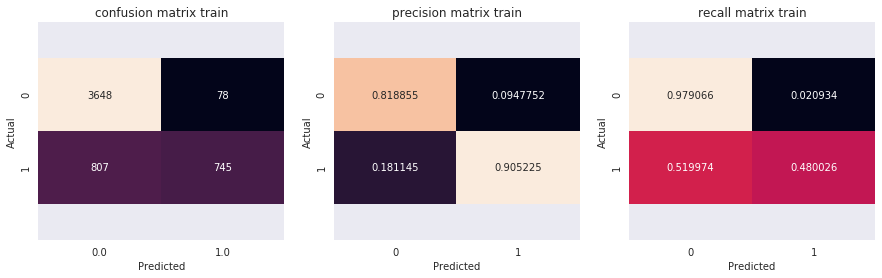

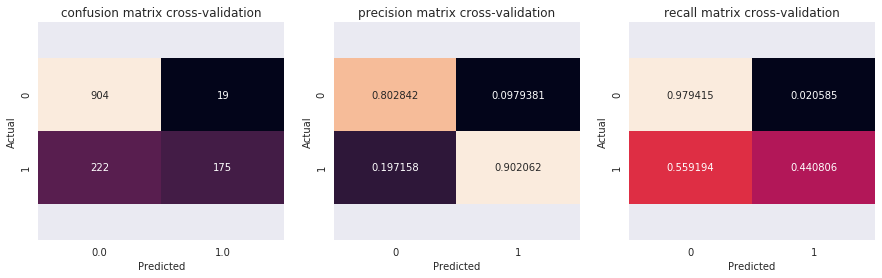

In [37]:
predicted = (mlp_model.predict(X_train, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(tr, pred, 'train')

predicted = (mlp_model.predict(X_cv, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(list(cv), pred, 'cross-validation')

### **Model training and evaluation for data with normalization**

In [0]:
mlp_model2 = Model(start, end)
mlp_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
history_2 = mlp_model2.fit(x = X_train_n, y=y_train_n, batch_size=100, epochs=10, validation_data=(X_cv_n, y_cv_n), 
                          callbacks=[roc_callback(training_data=[X_train_n, y_train_n],validation_data=[X_cv_n, y_cv_n] )])

Train on 5278 samples, validate on 1320 samples
Epoch 1/10
roc-auc: 0.8973 - roc-auc_val: 0.8967                                                                                                    
5278/5278 [==============================] - 1s 115us/sample - loss: 0.4142 - acc: 0.8439 - val_loss: 0.3420 - val_acc: 0.8538
Epoch 2/10
roc-auc: 0.9456 - roc-auc_val: 0.9413                                                                                                    
5278/5278 [==============================] - 0s 75us/sample - loss: 0.3330 - acc: 0.8439 - val_loss: 0.2733 - val_acc: 0.8538
Epoch 3/10
roc-auc: 0.9615 - roc-auc_val: 0.9551                                                                                                    
5278/5278 [==============================] - 0s 82us/sample - loss: 0.2817 - acc: 0.8439 - val_loss: 0.2511 - val_acc: 0.8538
Epoch 4/10
roc-auc: 0.9744 - roc-auc_val: 0.9687                                                                              

validation score: 0.151956085544644
validation accuracy: 0.95


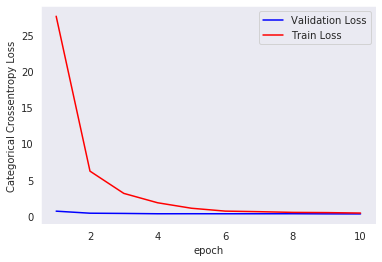

In [40]:
score = mlp_model2.evaluate(X_cv_n, y_cv_n, verbose=0) # getting model scores
print('validation score:', score[0])
print('validation accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,10+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

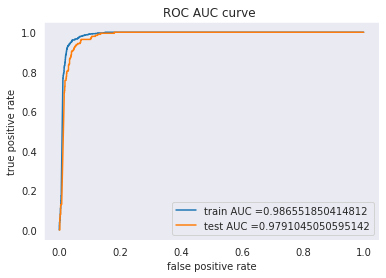

In [41]:

y_train_pred = list(mlp_model2.predict(X_train_n, batch_size=100))
y_cv_pred = list(mlp_model2.predict(X_cv_n))
tr = []
cv = []
tr_pr = []
cv_pr = []
for i in range(len(y_train_pred)):
    tr_pr.append(y_train_pred[i][1])
    tr.append(y_train_n[i][1])
for i in range(len(y_cv_pred)):
    cv_pr.append(y_cv_pred[i][1])
    cv.append(y_cv_n[i][1])
train_fpr, train_tpr, tr_thresholds = roc_curve(tr, tr_pr)
test_fpr, test_tpr, test_thresholds = roc_curve(cv, cv_pr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC AUC curve ")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.9193002035914047 for threshold 0.4


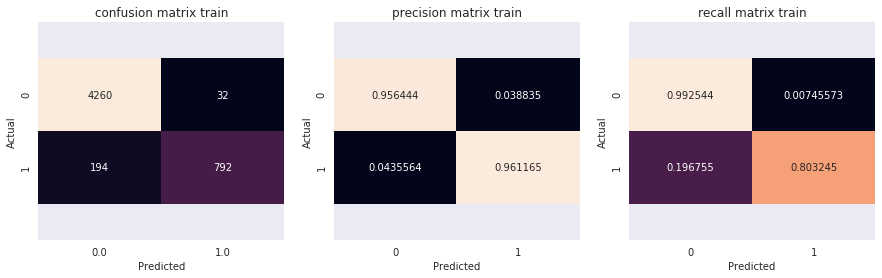

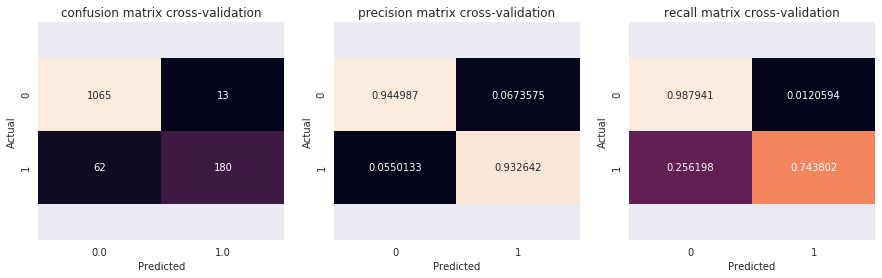

In [42]:
predicted = (mlp_model2.predict(X_train_n, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(tr, pred, 'train')

predicted = (mlp_model2.predict(X_cv_n, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(list(cv), pred, 'cross-validation')


**Summary of Multilayer perceptron model**

* The validation score and auc is better for the data with normalization

* The precision and recall is also better for the data with normalization.

## Model with 1D convolution layer

In [0]:
X_train = np.expand_dims(X_train, axis=2).astype(float)
X_cv = np.expand_dims(X_cv, axis=2).astype(float)
X_train_n = np.expand_dims(X_train_n, axis=2).astype(float)
X_cv_n = np.expand_dims(X_cv_n, axis=2).astype(float)

In [0]:
start = Input(shape=(166,1))
layer = Conv1D(32, 4, padding='same')(start)
layer = Flatten()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dense(64, activation='relu')(layer)
end = Dense(2, activation='softmax')(layer)

In [0]:
conv_model = Model(start, end)
conv_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [46]:

history_1 = conv_model.fit(x = X_train, y=y_train, batch_size=100, epochs=15, validation_data=(X_cv, y_cv), 
                          callbacks=[roc_callback(training_data=[X_train, y_train],validation_data=[X_cv, y_cv] )])

Train on 5278 samples, validate on 1320 samples
Epoch 1/15
roc-auc: 0.9611 - roc-auc_val: 0.9598                                                                                                    
5278/5278 [==============================] - 6s 1ms/sample - loss: 7.7562 - acc: 0.8280 - val_loss: 0.7648 - val_acc: 0.8538
Epoch 2/15
roc-auc: 0.9556 - roc-auc_val: 0.9644                                                                                                    
5278/5278 [==============================] - 0s 73us/sample - loss: 0.4038 - acc: 0.9337 - val_loss: 0.3428 - val_acc: 0.9083
Epoch 3/15
roc-auc: 0.9721 - roc-auc_val: 0.9658                                                                                                    
5278/5278 [==============================] - 0s 72us/sample - loss: 0.2748 - acc: 0.9454 - val_loss: 0.2996 - val_acc: 0.9273
Epoch 4/15
roc-auc: 0.9904 - roc-auc_val: 0.9881                                                                                

validation score: 0.08864995590411126
validation accuracy: 0.97424245


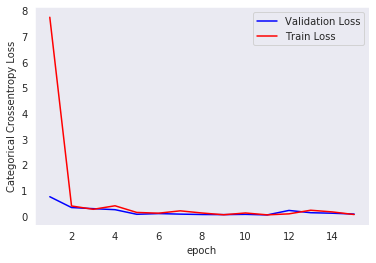

In [47]:
score = conv_model.evaluate(X_cv, y_cv, verbose=0) # getting model scores
print('validation score:', score[0])
print('validation accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,15+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

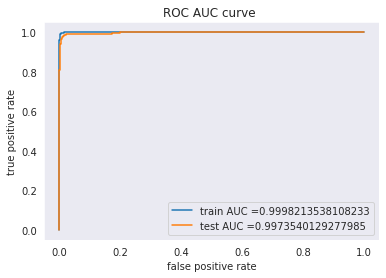

In [48]:
y_train_pred = list(conv_model.predict(X_train, batch_size=1000))
y_cv_pred = list(conv_model.predict(X_cv))
tr = []
cv = []
tr_pr = []
cv_pr = []
for i in range(len(y_train_pred)):
    tr_pr.append(y_train_pred[i][1])
    tr.append(y_train[i][1])
for i in range(len(y_cv_pred)):
    cv_pr.append(y_cv_pred[i][1])
    cv.append(y_cv[i][1])
train_fpr, train_tpr, tr_thresholds = roc_curve(tr, tr_pr)
test_fpr, test_tpr, test_thresholds = roc_curve(cv, cv_pr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC AUC curve ")
plt.grid()
plt.show()


the maximum value of tpr*(1-fpr) 0.9892394990815404 for threshold 0.914


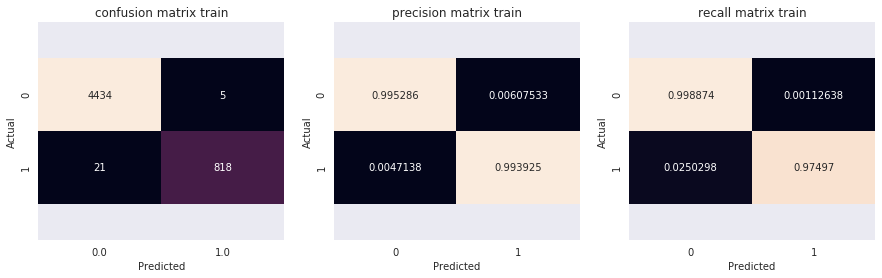

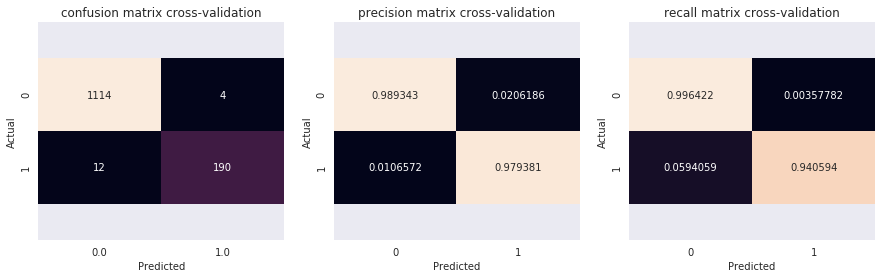

In [49]:

predicted = (conv_model.predict(X_train, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(tr, pred, 'train')

predicted = (conv_model.predict(X_cv, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(list(cv), pred, 'cross-validation')

In [0]:
conv_model2 = Model(start, end)
conv_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
history_2 = conv_model2.fit(x = X_train_n, y=y_train_n, batch_size=100, epochs=15, validation_data=(X_cv_n, y_cv_n), 
                          callbacks=[roc_callback(training_data=[X_train_n, y_train_n],validation_data=[X_cv_n, y_cv_n] )])

Train on 5278 samples, validate on 1320 samples
Epoch 1/15
roc-auc: 0.9543 - roc-auc_val: 0.9458                                                                                                    
5278/5278 [==============================] - 1s 121us/sample - loss: 0.3296 - acc: 0.8594 - val_loss: 0.2243 - val_acc: 0.9189
Epoch 2/15
roc-auc: 0.985 - roc-auc_val: 0.9832                                                                                                    
5278/5278 [==============================] - 0s 86us/sample - loss: 0.1633 - acc: 0.9415 - val_loss: 0.1148 - val_acc: 0.9591
Epoch 3/15
roc-auc: 0.9942 - roc-auc_val: 0.9913                                                                                                    
5278/5278 [==============================] - 0s 86us/sample - loss: 0.1043 - acc: 0.9619 - val_loss: 0.0873 - val_acc: 0.9712
Epoch 4/15
roc-auc: 0.9969 - roc-auc_val: 0.9945                                                                               

validation score: 0.027596757273457832
validation accuracy: 0.9886364


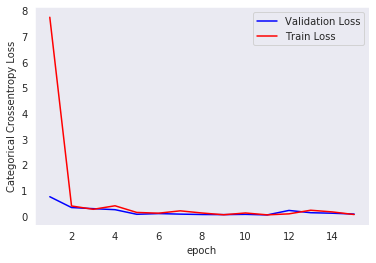

In [52]:
score = conv_model.evaluate(X_cv_n, y_cv_n, verbose=0) # getting model scores
print('validation score:', score[0])
print('validation accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') 
ax.set_ylabel('Categorical Crossentropy Loss')
# list of epoch numbers
x = list(range(1,15+1))
vy = history_1.history['val_loss']
ty = history_1.history['loss']
plt_dynamic(x, vy, ty, ax)

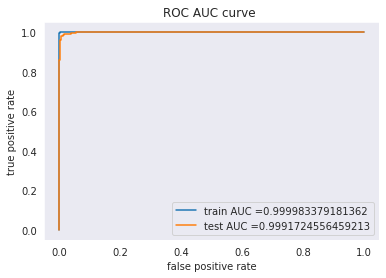

In [53]:

y_train_pred = list(conv_model.predict(X_train_n, batch_size=1000))
y_cv_pred = list(conv_model.predict(X_cv_n))
tr = []
cv = []
tr_pr = []
cv_pr = []
for i in range(len(y_train_pred)):
    tr_pr.append(y_train_pred[i][1])
    tr.append(y_train_n[i][1])
for i in range(len(y_cv_pred)):
    cv_pr.append(y_cv_pred[i][1])
    cv.append(y_cv_n[i][1])
train_fpr, train_tpr, tr_thresholds = roc_curve(tr, tr_pr)
test_fpr, test_tpr, test_thresholds = roc_curve(cv, cv_pr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC AUC curve ")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.9957341715312079 for threshold 0.409


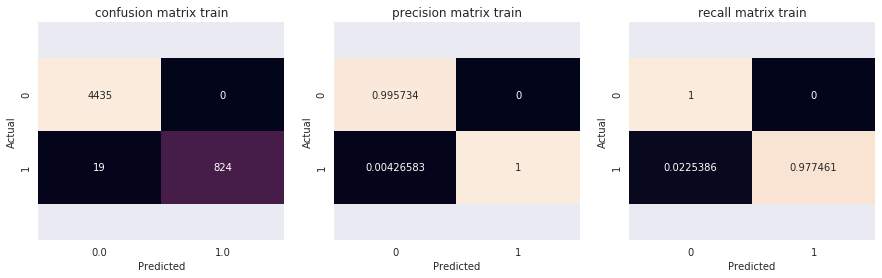

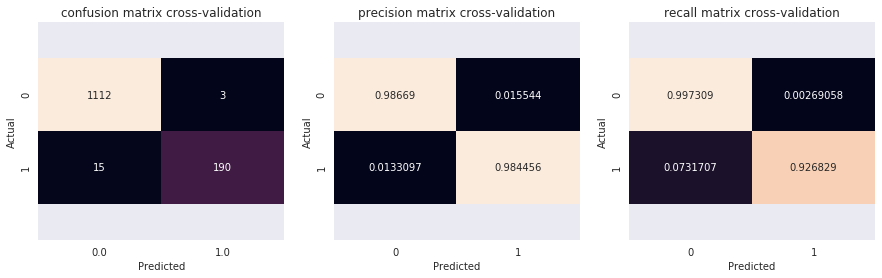

In [54]:
predicted = (conv_model.predict(X_train_n, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(tr, pred, 'train')

predicted = (conv_model.predict(X_cv_n, batch_size=100)).tolist()
predicted = [i[1] for i in predicted]
pred = predict_with_best_t(predicted, best_t)
confussion_matrix(list(cv), pred, 'cross-validation')

**Summary for Convolution model**

* In the convolution model also, the validation and auc score is better for the data with normalization.

* The precision and recall is also better for data with normalization

**Conclusion:**
* In b/w the above models and the model with convolution layer and normalized data performes better as the validation score, roc-auc score, precision and recall all the performance metrics are better than others.

In [0]:
conv_model.save('/gdrive/My Drive/Colab Notebooks/Internship/Musk AND Non-Musk Molecule/conv_model2.h5')